In [1]:
import tensorflow as tf 
import matplotlib.pyplot as plt
import numpy as np 
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
datagen = ImageDataGenerator(rescale=1./255,
                                      zoom_range=0.2,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      validation_split=0.2
                                      )
train_data = datagen.flow_from_directory('C:\\Users\\santhosh\\OneDrive\\Desktop\\diabetic retinopathy\\train\\',
                                                     target_size=(224,224),
                                                     batch_size=32,
                                                     class_mode = 'categorical',
                                                     subset = 'training')

valid_data = datagen.flow_from_directory('C:\\Users\\santhosh\\OneDrive\\Desktop\\diabetic retinopathy\\validation\\',
                                                     target_size=(224,224),
                                                     batch_size=32,
                                                     class_mode = 'categorical',
                                                     subset = 'validation')

Found 2931 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [3]:
import efficientnet.tfkeras as efn

In [3]:
def lr_rate(epoch,lr):
    if epoch<10:
        lr=0.0001
        return lr
    elif epoch<=15:
        lr=0.00001
        return lr
    elif epoch<=30:
        lr=0.00001
        return lr
    else:
        lr=lr*(epoch/(1+epoch))
        return lr
lr_callback=tf.keras.callbacks.LearningRateScheduler(lr_rate)

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, Accuracy

In [22]:
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
    
def f1score(y_true, y_pred):
    
    # Update state and get precision/recall values
    precision.update_state(y_true, y_pred)
    recall.update_state(y_true, y_pred)
    p = precision.result()
    r = recall.result()
    
    # Compute F1-Score
    f1 = 2 * (p * r) / (p + r + tf.keras.backend.epsilon())  # Avoid division by zero
    return f1

In [6]:
from tensorflow.keras.layers import Dense, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import efficientnet.tfkeras as efn

input_layer = Input(shape=(224, 224, 3))

base_model = efn.EfficientNetB0(
    input_shape=(224, 224, 3),
    weights='imagenet',
    include_top=False
)

for layer in base_model.layers:
    layer.trainable = True

x = base_model(input_layer)

x = GlobalAveragePooling2D()(x)

x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)

output_layer = Dense(5, activation='softmax')(x)

retinopathy_model = Model(inputs=input_layer, outputs=output_layer)

retinopathy_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy",Precision(), Recall(), f1score])
retinopathy_model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnet-b0 (Functional)    │ (None, 7, 7, 1280)     │     4,049,564 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,838,049 (18.46 MB)

 Trainable params: 4,796,033 (18.30 MB)

 Non-trainable params: 42,016 (164.12 KB)

In [7]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history=retinopathy_model.fit(train_data,validation_data = valid_data,callbacks=[early_stopping,lr_scheduler],epochs=100,verbose=1)

c:\Users\santhosh\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - accuracy: 0.6356 - f1score: 0.4918 - loss: 0.9509 - precision_1: 0.7910 - recall_1: 0.4969 - val_accuracy: 0.5636 - val_f1score: 0.6746 - val_loss: 2.2716 - val_precision_1: 0.5848 - val_recall_1: 0.5376 - learning_rate: 0.0010
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.7727 - f1score: 0.6792 - loss: 0.6174 - precision_1: 0.8474 - recall_1: 0.7005 - val_accuracy: 0.5499 - val_f1score: 0.6989 - val_loss: 1.6609 - val_precision_1: 0.5586 - val_recall_1: 0.5349 - learning_rate: 0.0010
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step - accuracy: 0.7934 - f1score: 0.7001 - loss: 0.5470 - precision_1: 0.8493 - recall_1: 0.7309 - val_accuracy: 0.7551 - val_f1score: 0.7189 - val_loss: 0.7151 - val_precision_1: 0.8111 - val_recall_1: 0.7223 - learning_rate: 0.0010
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.8112 - f1score: 0.7254 - loss: 0.5252 - precision_1: 0.8531 - recall_1: 0.7526 - val_acc

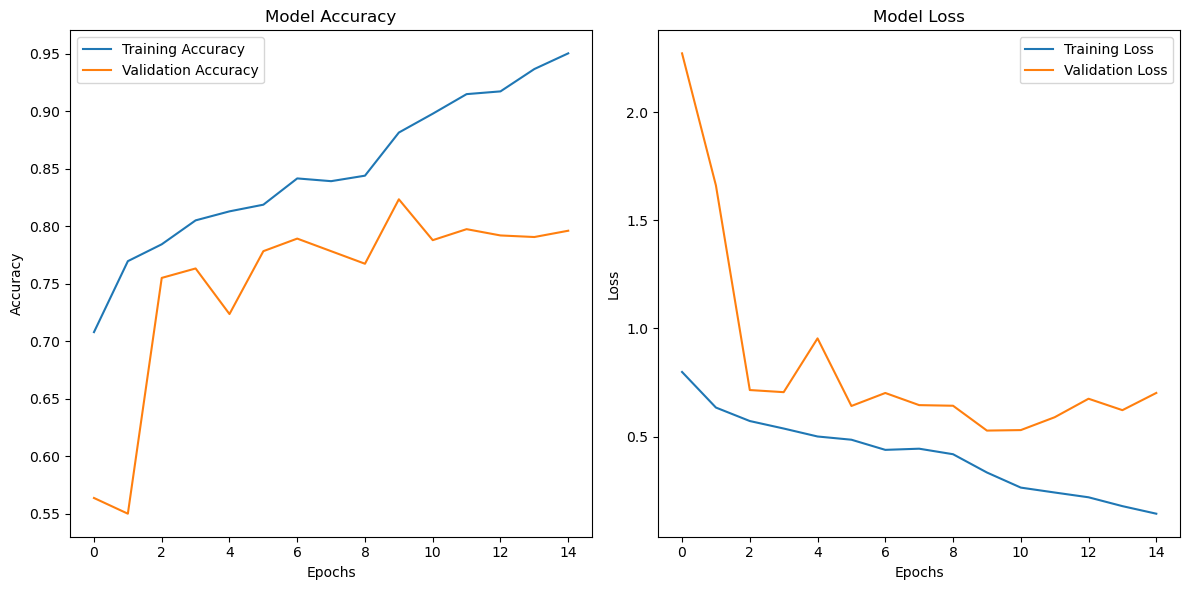

In [8]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [9]:
print(history.history.keys())

dict_keys(['accuracy', 'f1score', 'loss', 'precision_1', 'recall_1', 'val_accuracy', 'val_f1score', 'val_loss', 'val_precision_1', 'val_recall_1', 'learning_rate'])


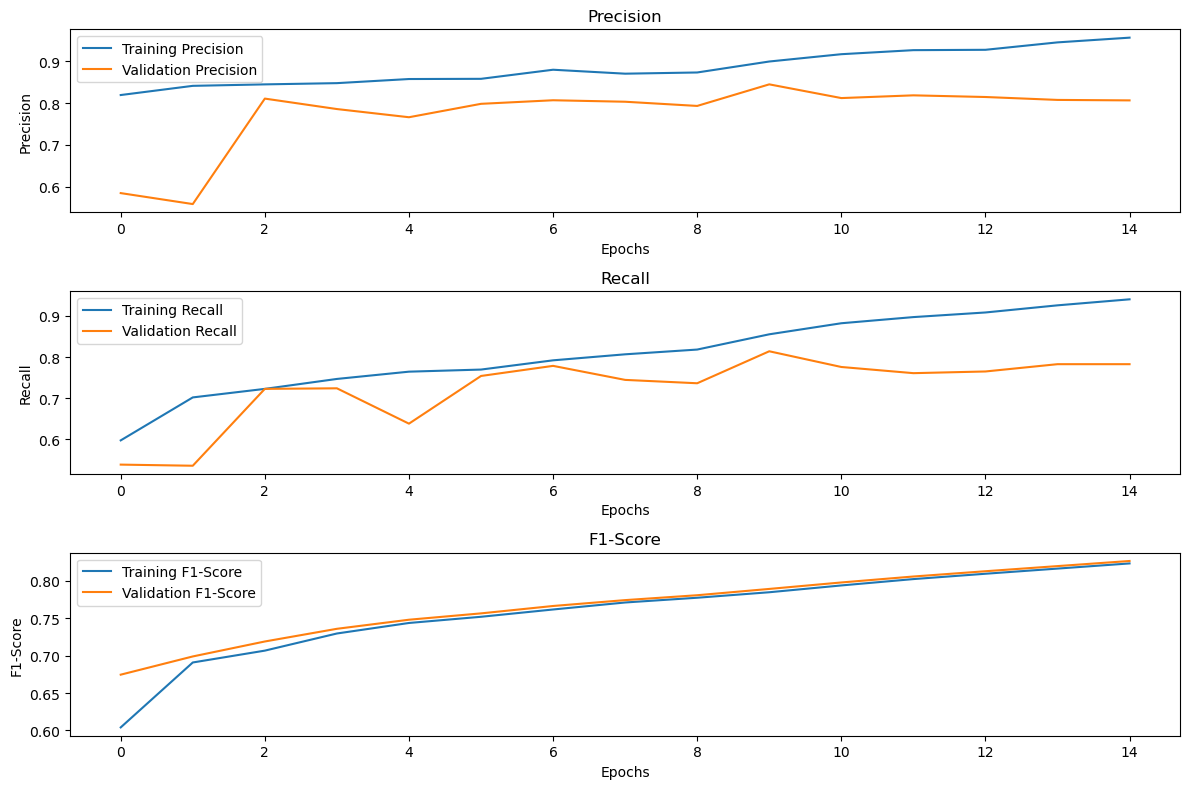

In [10]:
# Plot Precision, Recall, and F1-Score
plt.figure(figsize=(12, 8))

# Precision
plt.subplot(3, 1, 1)
plt.plot(history.history['precision_1'], label='Training Precision')
plt.plot(history.history['val_precision_1'], label='Validation Precision')
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Recall
plt.subplot(3, 1, 2)
plt.plot(history.history['recall_1'], label='Training Recall')
plt.plot(history.history['val_recall_1'], label='Validation Recall')
plt.title('Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

# F1-Score
plt.subplot(3, 1, 3)
plt.plot(history.history['f1score'], label='Training F1-Score')
plt.plot(history.history['val_f1score'], label='Validation F1-Score')
plt.title('F1-Score')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.legend()

plt.tight_layout()
plt.show()


In [15]:
test_generator =datagen.flow_from_directory(
    directory=r'C:\Users\santhosh\OneDrive\Desktop\diabetic retinopathy\testing',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)
result=retinopathy_model.evaluate(test_generator)

Found 3662 images belonging to 5 classes.


c:\Users\santhosh\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


115/115 ━━━━━━━━━━━━━━━━━━━━ 46s 399ms/step - accuracy: 0.8532 - f1score: 0.8313 - loss: 0.3959 - precision_1: 0.8719 - recall_1: 0.8381


In [16]:
y_pred = np.argmax(retinopathy_model.predict(test_generator), axis=-1) 
y_true = test_generator.classes 

correct_predictions = np.sum(y_pred == y_true)
total_samples = len(y_true)

print(f"Number of correctly classified samples: {correct_predictions} out of {total_samples}")
print(f"Accuracy (in numbers): {correct_predictions}")

115/115 ━━━━━━━━━━━━━━━━━━━━ 66s 573ms/step
Number of correctly classified samples: 3274 out of 3662
Accuracy (in numbers): 3274


In [17]:
accuracy = result[1] 
precision = precision_score(y_true, y_pred, average='weighted') 
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
loss=result[0]


print(f"Model accuracy: {accuracy * 100:.2f}%")
print(f"Model loss: {loss * 100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1-Score: {f1*100:.2f}%")

Model accuracy: 89.76%
Model loss: 28.29%
Precision: 89.84%
Recall: 89.40%
F1-Score: 88.76%


In [18]:
import cv2

def predict_new(path):
    img = cv2.imread(path)
    predictions=["Mild","Moderate","NO_DR","Proliferate_DR","Severe"] 
    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    RGBImg= cv2.resize(RGBImg,(224,224))
    plt.imshow(RGBImg)
    image = np.array(RGBImg) / 255.0

    predict=retinopathy_model.predict(np.array([image]))
    pred=np.argmax(predict,axis=1)
    
    print(f"Predicted: {predictions[pred[0]]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted: Proliferate_DR


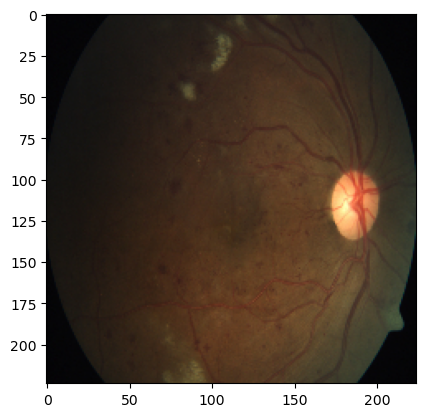

In [20]:
predict_new(r'C:\Users\santhosh\OneDrive\Desktop\diabetic retinopathy\train\Severe\3f49f8d100e9.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted: Proliferate_DR


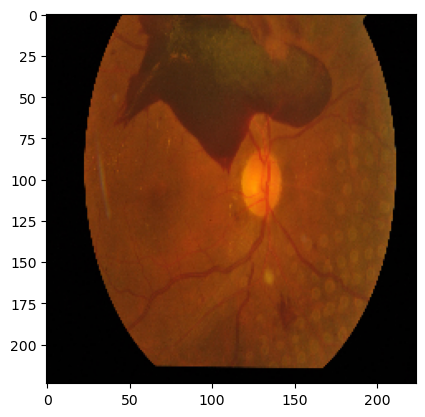

In [21]:
predict_new(r'C:\Users\santhosh\OneDrive\Desktop\diabetic retinopathy\train\Proliferate_DR\0e0fc1d9810c.png')

In [40]:
retinopathy_model.save(r'C:\Users\santhosh\OneDrive\Desktop\diabetic retinopathy\combinedmodel.keras')


In [43]:
conv_layers = [layer for layer in model.layers[1].layers if 'conv' in layer.name.lower()]
print(conv_layers[-1].name)


top_conv


In [62]:
!pip install lime

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283841 sha256=85a21e754d0145506120416c82731bb98fcef50d68ceef0b631d82f28503ab7a
  Stored in directory: c:\users\santhosh\appdata\local\pip\cache\wheels\e7\5d\0e\4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

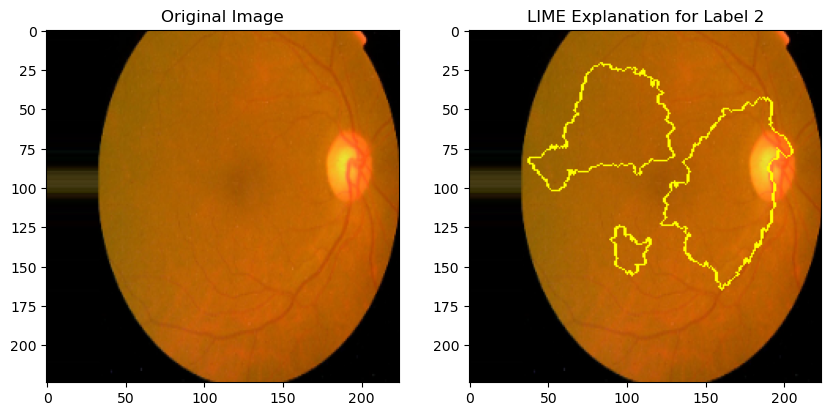

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Define a prediction function that LIME can use (classifier_fn)
def classifier_fn(images):
    # No need to normalize the images here since ImageDataGenerator already did it
    return retinopathy_model.predict(images)

# Instantiate the LIME image explainer
explainer = lime_image.LimeImageExplainer()

# Select a batch of images from your train_data generator
X_train, _ = next(train_data)  # Using next() to get the next batch

# Select the first image from the batch for explanation (you can change the index if needed)
image_to_explain = X_train[0]  # You can change this to any other image in the batch

# Explain the image using LIME
explanation = explainer.explain_instance(image_to_explain, 
                                         classifier_fn,  # Pass the classifier function here
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000)  # 1000 perturbed images

# Get the explanation for the top predicted label
top_label = explanation.top_labels[0]

# Visualize the explanation: Highlight important areas for the top label
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Original image
ax[0].imshow(image_to_explain)
ax[0].set_title('Original Image')

# LIME explanation: Overlay the mask on the original image
explanation_image, mask = explanation.get_image_and_mask(top_label, 
                                                         positive_only=True, 
                                                         num_features=5, 
                                                         hide_rest=False)

# Apply the mask to the original image and visualize the important areas
explained_image = mark_boundaries(image_to_explain, mask)

# Ensure the image data is in the correct type for visualization
explained_image = np.array(explained_image, dtype=np.float32)

# Plot the explanation image
ax[1].imshow(explained_image)
ax[1].set_title(f'LIME Explanation for Label {top_label}')

plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

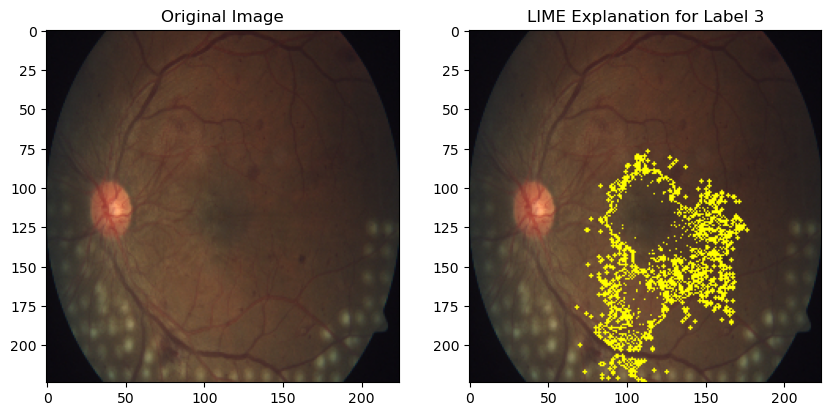

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from skimage.segmentation import mark_boundaries
from tensorflow.keras.models import load_model
 # Replace with your model path

# Define a classifier function for LIME
def classifier_fn(images):
    images = images / 255.0  # Rescale to [0, 1] if needed (same as training data)
    return retinopathy_model.predict(images)

# Instantiate the LIME image explainer
explainer = lime_image.LimeImageExplainer()

# Load and preprocess a specific image from the test set
image_path = r'C:\Users\santhosh\OneDrive\Desktop\diabetic retinopathy\train\Proliferate_DR\0bf37ca3156a.png'  # Replace with the path to your image
image = load_img(image_path, target_size=(224, 224))  # Resize to the target size
image_array = img_to_array(image)  # Convert the image to a numpy array
image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

# Use LIME to explain the image
explanation = explainer.explain_instance(image_array[0],  # The image to explain
                                         classifier_fn,  # The classifier function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000)  # Number of perturbed samples

# Get the explanation for the top predicted label
top_label = explanation.top_labels[0]

# Visualize the explanation
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Display the original image
ax[0].imshow(image_array[0].astype('uint8'))  # Convert to uint8 for proper visualization
ax[0].set_title('Original Image')

# LIME explanation: Overlay the mask on the original image
explanation_image, mask = explanation.get_image_and_mask(top_label, 
                                                         positive_only=True, 
                                                         num_features=5, 
                                                         hide_rest=False)

# The mask returned by LIME is a binary mask, so we combine it with the original image.
explained_image = mark_boundaries(image_array[0].astype('uint8'), mask)

# Display the explained image with boundaries
ax[1].imshow(explained_image)
ax[1].set_title(f'LIME Explanation for Label {top_label}')

plt.show()
